# SOAR-4m Goodman Spectrograph Quick-Reduce Notebook

### 0. Background

This notebook will do a quick-and-dirty processing, wavelength calibration, and spectrophotometic calibration of a spectrum obtained with the SOAR-4m Goodman Spectrograph, using just an observed spectrum of an Hamuy Tertiary Standard Star (for spectrophotometric calibration) and an observed spectrum of the target object taken with the same Goodman configuration (e.g., the 400_WD mode, binned 2x2). No bias frames or flat fields are required for this quick-and-dirty processing. (A single wavecal frame is needed merely to identify a single line and its corresponding column and wavelength, for a rough wavelength calibration.)

The Hamuy Tertiary Standards and their coordinates can be found here: http://www.ctio.noao.edu/soar/content/hamuy-spectrophotometric-standards .

A Look-up Table that translates from the Hamuy Tertiary Standard Star Name and the corresponding IRAF File name that contains the star's spectrophotometricly calibrated SED can be found below.



** Look-up Table:  Hamuy Tertiary Standard Star Names to IRAF Calibrated Spectrum Filenames **

| Star Name   | IRAF File | Comments |
| ----------  | --------- | -------- |
| CD-32 9927  | cd32.dat  |          |
| CD-34 241   | l377.dat  | CD-34 241 is mistakenly named LTT 377 in Stone & Baldwin (1983) and in Hamuy et al. (1992 & 1994) |          
| EG 21       | eg21.dat  |          |            
| EG 274      | eg274.dat |          |          
| Feige 56    | f56.dat   |          |           
| Feige 110   | f110.dat  |          |          
| Hiltner 600 | h600.dat  |          |          
| LTT 745     | l745.dat  | Not on SOAR list of Hamuy Tertiary Standards |
| LTT1020     | l1020.dat |          |         
| LTT 1788    | l1788.dat |          |         
| LTT 2415    | l2415.dat |          |         
| LTT 3218    | l3218.dat |          |         
| LTT 3864    | l3864.dat |          |         
| LTT 4364    | l4364.dat |          |         
| LTT 4816    | l4816.dat |          |         
| LTT 6248    | l6248.dat |          |         
| LTT 7379    | l7379.dat |          |         
| LTT 7987    | l7987.dat |          |
| LTT 9239    | l9239.dat |          |
| LTT 9491    | l9491.dat |          |


### 1.  Initial Setup

In [1]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
#from astropy.table import Table
#import fitsio
from scipy import interpolate
import glob
import math
import os
import matplotlib.pyplot as plt

# We only use the pysynphot functions, not the pysynphot database, 
#  so we set PYSYN_CDBS to a dummy value to avoid scary warning messages...
#os.environ['PYSYN_CDBS'] = '/Users/dtucker/IRAF/SynphotData/grp/hst/cdbs/'
os.environ['PYSYN_CDBS'] = '/dummy/'
import pysynphot as S

%matplotlib inline

/Users/dtucker/anaconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /dummy/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/dtucker/anaconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /dummy/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/dtucker/anaconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /dummy/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


### 2.  User Inputs

Change as needed.  Some of the values will change for each target (e.g., the target file name); others will remain constant throughout the night (e.g., the standard star file) or even longer term (the windows for the *_aper_row_min/*_aper_row_max and *_small_plot_row_min/*_small_plot_row_max).

In [2]:
#############################################################################
#
# User inputs...
#
#############################################################################

# Goodman configuration...

# Spectrum bin to wavelength conversion coefficients (linear).
#  The dispersion should be constant for grating 400 binned 2x2.
#  The value of wavelength0 should be measured each night.
#
# dispersion = (w2-w1)/(x2-x1)
# wavelength0 = w1 - m*x1
#  where w1, w2 are wavelengths 1 and 2 and 
#        x1, x2 are the x pixel positions corresponding to w1, w2, respectively.
# 
dispersion = 2.00 # Angstroms per pixel for grating 400 binned 2x2.
wavelength0 = 3088.  # Wavelength corresponding to spectrum bin 0.


# Standard star spectrum info...
#  Observed spectrum:
ss_dataDir='/Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-09-30'
ss_inputFile=ss_dataDir+'/0129_feige110.fits'    # change for different SS spectra
ss_aper_row_center = 455                         # change if center row of SS spectrum changes.
ss_aper_row_min = ss_aper_row_center - 5         # generally no need to change
ss_aper_row_max = ss_aper_row_center + 5         # generally no need to change
ss_small_plot_row_min = ss_aper_row_center - 50  # generally no need to change
ss_small_plot_row_max = ss_aper_row_center + 50  # generally no need to change
#  IRAF file...
ss_irafCalDir='/Users/dtucker/GitHub/SOAR_Goodman_QuickReduce/data/ctionewcal'
ssFile_short = 'f110.dat'                        # change for different SS stars
ssFile = os.path.join(ss_irafCalDir, ssFile_short)
#  Estimated response function (spectrophotometric calibration)...
ss_outputFile=ss_inputFile+'.calib.csv'          # generally no need to change


# Target spectrum
t_dataDir='/Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-10-01'
t_inputFile=t_dataDir+'/0325_obj1208.fits'      # change for different target spectra
t_calibFile=ss_outputFile                       # generally no need to change
t_outputFile=t_inputFile+'.1d_calib.csv'        # generally no need to change

t_aper_row_center = 475
t_aper_row_min = t_aper_row_center - 5          # generally no need to change
t_aper_row_max = t_aper_row_center + 5          # generally no need to change
t_small_plot_row_min = t_aper_row_center - 50   # generally no need to change
t_small_plot_row_max = t_aper_row_center + 50   # generally no need to change


### 3.  Standard Star Spectrum

Just need to do this once per night.  The instrumental response is saved to a calibration file, and, as long as the Goodman configuration is not changed, the same calibration can be used for all the targets taken that night.

('Min:', 629)
('Max:', 53641)
('Mean:', 641.6852231030485)
('Stdev:', 52.4005623586233)
[3088. 3090. 3092. ... 7224. 7226. 7228.]
[0. 0. 0. ... 0. 0. 0.]


* * * Spectrophotometric calibration written to /Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-09-30/0129_feige110.fits.calib.csv * * *




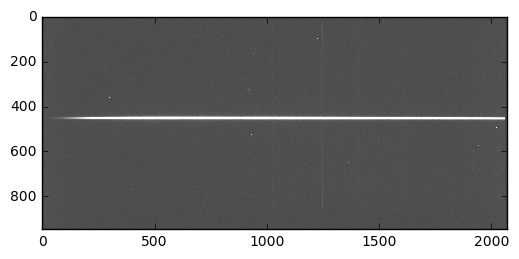

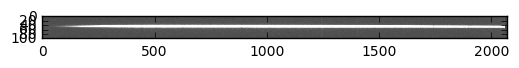

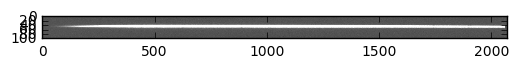

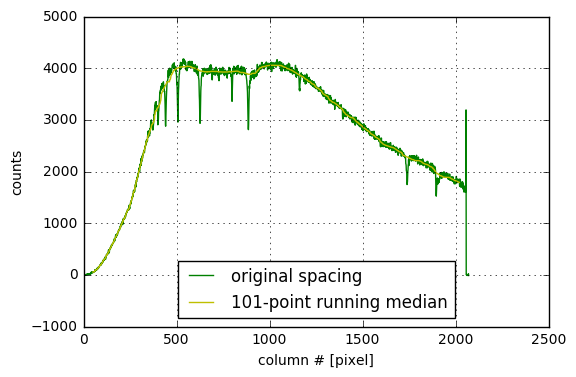

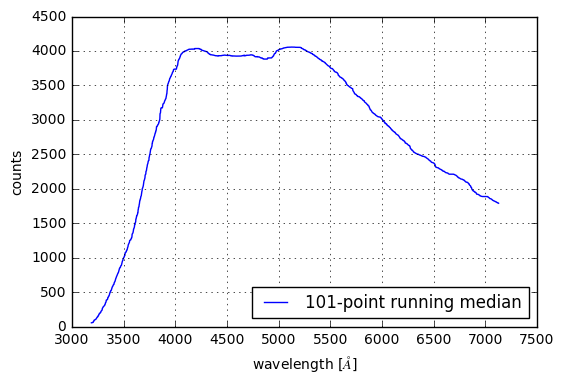

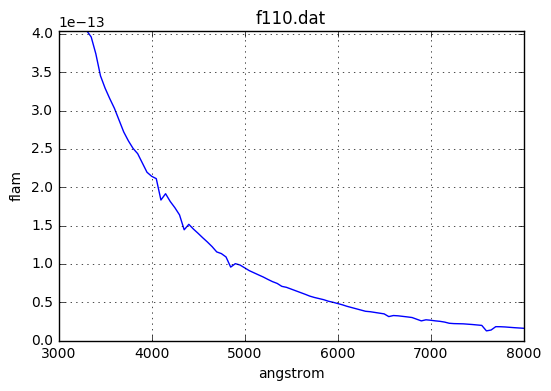

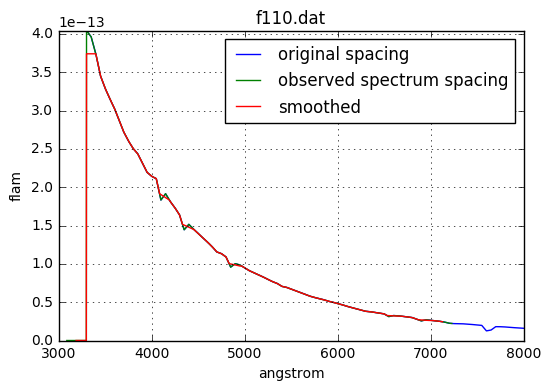

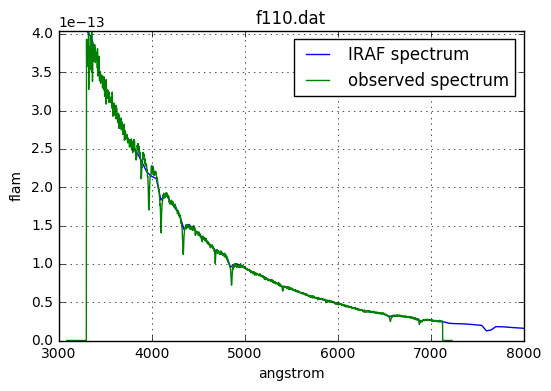

In [3]:
# Standard Star Spectrum...

#############################################################################
#
# Deal with observed spectrum...
#
#############################################################################

inputFile = ss_inputFile
outputFile = ss_outputFile

aper_row_center = ss_aper_row_center
aper_row_min = ss_aper_row_min
aper_row_max = ss_aper_row_max

small_plot_row_min = ss_small_plot_row_min
small_plot_row_max = ss_small_plot_row_max

image_data = fits.getdata(inputFile)

print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

vmin = np.mean(image_data) - np.std(image_data)
vmax = np.mean(image_data) + 2.*np.std(image_data)

plt.figure(1)
plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
plt.figure(2)
plt.imshow(image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)

median1d = np.median(image_data[small_plot_row_min:small_plot_row_max,:],axis=0)

bkg_data = np.tile(median1d,[948,1])

new_image_data = image_data-bkg_data

vmin = 0.00 - np.std(image_data)
vmax = 0.00 + 2.*np.std(image_data)


plt.figure(5)
plt.imshow(new_image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)

sum1d = np.sum(new_image_data[aper_row_min:aper_row_max,:],axis=0)


x=np.arange(0,2071)


# Running median...
x_series = pd.Series(x, name='x')
sum1d_series = pd.Series(sum1d, name='counts')
df_sum1d = pd.concat([x_series,sum1d_series], axis=1)
df_sum1d.loc[:,'wavelength'] = dispersion*df_sum1d.loc[:,'x'] + wavelength0
wave = df_sum1d.wavelength.values
df_sum1d_smoothed = df_sum1d.rolling(101).median().dropna()
x_smoothed = df_sum1d_smoothed.x.values
wave_smoothed = df_sum1d_smoothed.wavelength.values
sum1d_smoothed = df_sum1d_smoothed.counts.values


plt.figure(6)
plt.plot(x, sum1d, 'g-', 
         x_smoothed, sum1d_smoothed, 'y-')
plt.legend(['original spacing', 
            '101-point running median'], 
           loc='best')
plt.xlabel("""column # [pixel]""")
plt.ylabel("counts")
plt.grid(True)

plt.figure(7)
plt.plot(wave_smoothed, sum1d_smoothed, 'b-')
plt.legend(['101-point running median'], 
           loc='best')
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel("counts")
plt.grid(True)



#############################################################################
#
# Deal with IRAF spectrum...
#
#############################################################################

# IRAF file...
ss_df_temp = pd.read_csv(ssFile, header=None, delim_whitespace=True, comment='#')
ss_wave = ss_df_temp[0].values
ss_abmag = ss_df_temp[1].values
ssSpectrum = S.ArraySpectrum(ss_wave,ss_abmag,name=ssFile_short,fluxunits='abmag')
ssSpectrum.convert('flam')

wavelo = 3000.
wavehi = 8000.
mask = ( (ssSpectrum.wave >= wavelo) & (ssSpectrum.wave <= wavehi) )
fluxhi = ssSpectrum.flux[mask].max()

plt.figure(8)
plt.plot(ssSpectrum.wave, ssSpectrum.flux)
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel(ssSpectrum.waveunits)
plt.ylabel(ssSpectrum.fluxunits)
plt.title(os.path.basename(ssSpectrum.name))
plt.grid(True)


ss_interp = interpolate.interp1d(ssSpectrum.wave.tolist(), ssSpectrum.flux.tolist(), 
                                 bounds_error=False, fill_value=0., 
                                 kind='linear')


flux_series = pd.Series(ss_interp(df_sum1d.wavelength), name='flam')
df_ss = pd.concat([df_sum1d.x,flux_series,df_sum1d.wavelength], axis=1)


# Running median...
df_ss_smoothed = df_ss.rolling(101).median().dropna()


plt.figure(9)
plt.plot(ssSpectrum.wave, ssSpectrum.flux, 'b-', 
         wave, ss_interp(wave), 'g-', 
        df_ss_smoothed.wavelength.values, df_ss_smoothed.flam.values, 'r-')
plt.legend(['original spacing', 
            'observed spectrum spacing',
            'smoothed'], 
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel(ssSpectrum.waveunits)
plt.ylabel(ssSpectrum.fluxunits)
plt.title(os.path.basename(ssSpectrum.name))
plt.grid(True)


df_ss_smoothed.loc[:,'ratio'] = df_ss_smoothed.loc[:,'flam'] / df_sum1d_smoothed.loc[:,'counts'] 
ratio_median = df_ss_smoothed.ratio.median()
df_ss_smoothed.loc[:,'rel_scale'] = df_ss_smoothed.loc[:,'ratio'] / ratio_median


calib_interp = interpolate.interp1d(df_ss_smoothed.wavelength.tolist(), 
                                    df_ss_smoothed.ratio.tolist(),  
                                     bounds_error=False, fill_value=0., 
                                     kind='linear')

print wave
print calib_interp(wave)

# problem here:
df_sum1d.loc[:,'Flam'] =  df_sum1d.loc[:,'counts'] * calib_interp(wave)


plt.figure(10)
plt.plot(ssSpectrum.wave, ssSpectrum.flux, 'b-', 
        df_sum1d.wavelength.values, df_sum1d.Flam.values, 'g-')
plt.legend(['IRAF spectrum', 
            'observed spectrum'],
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel(ssSpectrum.waveunits)
plt.ylabel(ssSpectrum.fluxunits)
plt.title(os.path.basename(ssSpectrum.name))
plt.grid(True)


wave_series = pd.Series(wave, name='wave')
calib_series = pd.Series(calib_interp(wave), name='calib')
df_calib = pd.concat([wave_series,calib_series], axis=1)
df_calib.to_csv(outputFile,index=False)

print 
print
print """* * * Spectrophotometric calibration written to %s * * *""" % (outputFile)
print
print

### 4.  Target Object Spectrum

Run this section for each new target spectrum.  

Generally, you will run the Standard Star Spectrum once per night (preferably at the beginning of the night), and you will run the Target Object Spectrum section multiple times per night (changing the target spectrum info in the User Inputs section above as needed).

Note that the code for the Target Object Spectrum is nearly identical to that for the Standard Star Spectrum.

('Min:', 630)
('Max:', 56558)
('Mean:', 642.0507923362)
('Stdev:', 124.01303836346364)


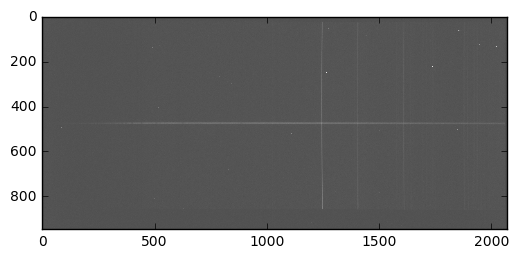

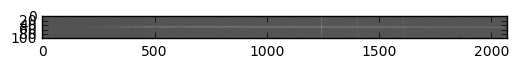

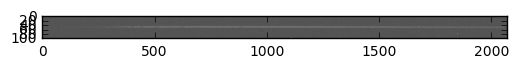

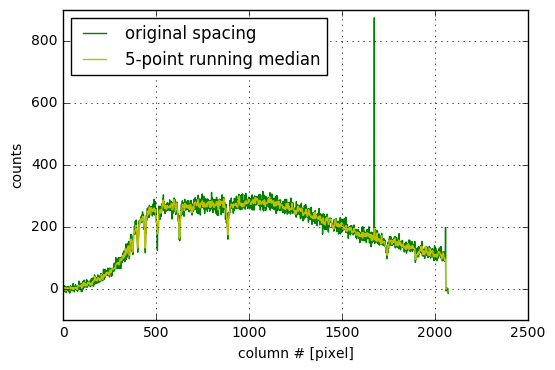

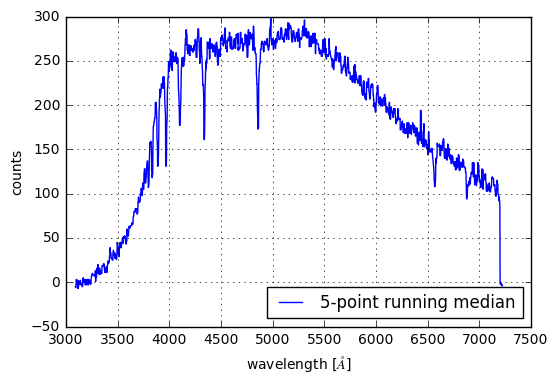

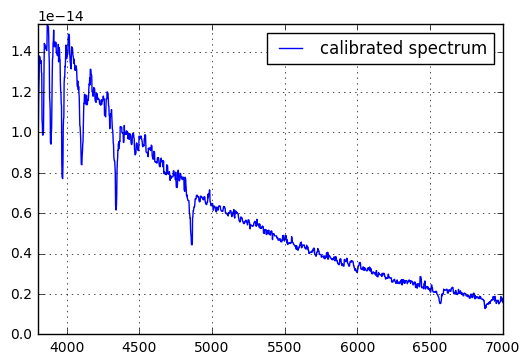

In [4]:
# Target Object Spectrum...

#############################################################################
#
# Deal with observed spectrum...
#
#############################################################################

inputFile = t_inputFile
calibFile = t_calibFile
outputFile = t_outputFile

aper_row_center = t_aper_row_center
aper_row_min = t_aper_row_min
aper_row_max = t_aper_row_max

small_plot_row_min = t_small_plot_row_min
small_plot_row_max = t_small_plot_row_max

image_data = fits.getdata(inputFile)

print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

vmin = np.mean(image_data) - np.std(image_data)
vmax = np.mean(image_data) + 2.*np.std(image_data)

plt.figure(1)
plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
plt.figure(2)
plt.imshow(image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)

median1d = np.median(image_data[small_plot_row_min:small_plot_row_max,:],axis=0)

bkg_data = np.tile(median1d,[948,1])

new_image_data = image_data-bkg_data

vmin = 0.00 - np.std(image_data)
vmax = 0.00 + 2.*np.std(image_data)


plt.figure(5)
plt.imshow(new_image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)

sum1d = np.sum(new_image_data[aper_row_min:aper_row_max,:],axis=0)


x=np.arange(0,2071)


# Running median...
x_series = pd.Series(x, name='x')
sum1d_series = pd.Series(sum1d, name='counts')
df_sum1d = pd.concat([x_series,sum1d_series], axis=1)
df_sum1d.loc[:,'wavelength'] = dispersion*df_sum1d.loc[:,'x'] + wavelength0
wave = df_sum1d.wavelength.values
df_sum1d_smoothed = df_sum1d.rolling(5).median().dropna()
x_smoothed = df_sum1d_smoothed.x.values
wave_smoothed = df_sum1d_smoothed.wavelength.values
sum1d_smoothed = df_sum1d_smoothed.counts.values


plt.figure(6)
plt.plot(x, sum1d, 'g-', 
         x_smoothed, sum1d_smoothed, 'y-')
plt.legend(['original spacing', 
            '5-point running median'], 
           loc='best')
plt.xlabel("""column # [pixel]""")
plt.ylabel("counts")
plt.grid(True)

plt.figure(7)
plt.plot(wave_smoothed, sum1d_smoothed, 'b-')
plt.legend(['5-point running median'], 
           loc='best')
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel("counts")
plt.grid(True)

df_sum1d_smoothed.to_csv(outputFile, index=False)


#############################################################################
#
# Read in calibFile and apply the spectrophotometric calibration...
#
#############################################################################

df_calib = pd.read_csv(calibFile)

calib_interp = interpolate.interp1d(df_calib.wave.tolist(), 
                                    df_calib.calib.tolist(),  
                                     bounds_error=False, fill_value=0., 
                                     kind='linear')


df_sum1d_smoothed.loc[:,'Flam'] =  df_sum1d_smoothed.loc[:,'counts'] * calib_interp(wave_smoothed)
sum1d_smoothed_calib = df_sum1d_smoothed.Flam.values

wavelo=3800.
wavehi=7000.
mask = ((df_sum1d_smoothed.wavelength >= 3500.) & (df_sum1d_smoothed.wavelength <= 7000.))
fluxhi = df_sum1d_smoothed[mask].Flam.max()

plt.figure(8)
plt.plot(wave_smoothed, sum1d_smoothed_calib, 'b-') 
plt.legend(['calibrated spectrum'], 
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
#plt.xlabel(ssSpectrum.waveunits)
#plt.ylabel(ssSpectrum.fluxunits)
#plt.title(os.path.basename(ssSpectrum.name))
plt.grid(True)


